In [1]:
#Importing libraries.
import datetime as dt
import os
import pickle
import urllib
import warnings
from datetime import datetime
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from scipy import stats as st
from scipy.stats import lognorm
from geopy import distance as dist 
from sklearn.cluster import KMeans
import numpy as np
from tabulate import tabulate
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
p = .2 # Just taking 20% of the data around 3 million rows
df = pd.read_csv(
         'data/2015_Green_Taxi_Trip_Data.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p)
df.head()

,vendorid,pickup_datetime,dropoff_datetime,Store_and_fwd_flag,rate_code,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,Improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,02/17/2015 05:04:16 AM,02/17/2015 05:34:04 AM,N,1,-73.927223,40.692600,-73.918312,40.651379,1,...,17.0,0.5,0.5,0.0,0.0,NaN,0.3,18.3,1,1.0
1,2,02/24/2015 05:39:08 PM,02/24/2015 05:54:11 PM,N,1,-73.920647,40.756992,-73.902565,40.770397,5,...,11.0,1.0,0.5,0.0,0.0,NaN,0.3,12.8,1,1.0
2,1,01/06/2015 02:16:47 PM,01/06/2015 02:26:49 PM,N,1,-73.861893,40.750164,-73.873062,40.735619,1,...,8.0,0.0,0.5,0.0,0.0,NaN,0.3,8.8,2,1.0
3,1,02/13/2015 07:49:20 PM,02/13/2015 07:53:49 PM,N,1,-73.994896,40.684578,-74.003479,40.680717,2,...,5.0,1.0,0.5,0.0,0.0,NaN,0.3,6.8,2,1.0
4,1,02/28/2015 02:53:21 PM,02/28/2015 03:03:08 PM,N,1,-73.948837,40.801811,-73.968918,40.799294,1,...,8.5,0.0,0.5,1.2,0.0,NaN,0.3,10.5,1,1.0


In [3]:
#rounded longitude & Latitude to 2 decimal places so that it could be merged to get the relevant cities
df['Pickup_longitude'] = df['Pickup_longitude'].round(2)
df['Pickup_latitude'] = df['Pickup_latitude'].round(2)

In [4]:
# merged two columns together for optimized search
df['corr'] = df.Pickup_longitude.astype(str).str.cat(df.Pickup_latitude.astype(str),sep=",")

In [5]:
# external data gathered from the NYC planing website for with latitude, longitude & city names (relevant for us)
df_nyc_city = pd.read_csv('data/us-zip-code-latitude-and-longitude.csv')
df_nyc_city

,City,Pickup_latitude,Pickup_longitude
0,Depew,42.904958,-78.700600
1,Owego,42.120274,-76.258740
2,Friendship,42.192384,-78.143080
3,North Babylon,40.733398,-73.322570
4,West Babylon,40.922326,-72.637078
...,...,...,...
2276,Sabael,43.667618,-74.456913
2277,Keeseville,44.483465,-73.480100
2278,Potsdam,44.651265,-74.952890
2279,Hensonville,42.302596,-74.227110


In [6]:
#similar approach as above
df_nyc_city['Pickup_longitude'] = df_nyc_city['Pickup_longitude'].round(2)
df_nyc_city['Pickup_latitude'] = df_nyc_city['Pickup_latitude'].round(2)

In [7]:
#similar approach as above
df_nyc_city['corr'] = df_nyc_city.Pickup_longitude.astype(str).str.cat(df_nyc_city.Pickup_latitude.astype(str),sep=",")

In [8]:
df_nyc_city

,City,Pickup_latitude,Pickup_longitude,corr
0,Depew,42.90,-78.70,"-78.7,42.9"
1,Owego,42.12,-76.26,"-76.26,42.12"
2,Friendship,42.19,-78.14,"-78.14,42.19"
3,North Babylon,40.73,-73.32,"-73.32,40.73"
4,West Babylon,40.92,-72.64,"-72.64,40.92"
...,...,...,...,...
2276,Sabael,43.67,-74.46,"-74.46,43.67"
2277,Keeseville,44.48,-73.48,"-73.48,44.48"
2278,Potsdam,44.65,-74.95,"-74.95,44.65"
2279,Hensonville,42.30,-74.23,"-74.23,42.3"


In [9]:
df.columns

Index(['vendorid', 'pickup_datetime', 'dropoff_datetime', 'Store_and_fwd_flag',
       'rate_code', 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude',
       'Dropoff_latitude', 'Passenger_count', 'Trip_distance', 'Fare_amount',
       'Extra', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'Ehail_fee',
       'Improvement_surcharge', 'Total_amount', 'Payment_type', 'Trip_type',
       'corr'],
      dtype='object')

In [10]:
print("Number of rows:", df.shape[0])
print("Number of Columns:", df.shape[1])

Number of rows: 3848056
Number of Columns: 22


In [11]:
df_nyc_city.shape

(2281, 4)

In [12]:
# mapped cities name in NYC state which reconcile with corrdinates
df_merged = pd.merge(df, df_nyc_city, how='left', on=['corr'])


In [13]:
df_merged

,vendorid,pickup_datetime,dropoff_datetime,Store_and_fwd_flag,rate_code,Pickup_longitude_x,Pickup_latitude_x,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Tolls_amount,Ehail_fee,Improvement_surcharge,Total_amount,Payment_type,Trip_type,corr,City,Pickup_latitude_y,Pickup_longitude_y
0,2,02/17/2015 05:04:16 AM,02/17/2015 05:34:04 AM,N,1,-73.93,40.69,-73.918312,40.651379,1,...,0.0,NaN,0.3,18.3,1,1.0,"-73.93,40.69",Brooklyn,40.69,-73.93
1,2,02/24/2015 05:39:08 PM,02/24/2015 05:54:11 PM,N,1,-73.92,40.76,-73.902565,40.770397,5,...,0.0,NaN,0.3,12.8,1,1.0,"-73.92,40.76",NaN,NaN,NaN
2,1,01/06/2015 02:16:47 PM,01/06/2015 02:26:49 PM,N,1,-73.86,40.75,-73.873062,40.735619,1,...,0.0,NaN,0.3,8.8,2,1.0,"-73.86,40.75",Corona,40.75,-73.86
3,1,02/13/2015 07:49:20 PM,02/13/2015 07:53:49 PM,N,1,-73.99,40.68,-74.003479,40.680717,2,...,0.0,NaN,0.3,6.8,2,1.0,"-73.99,40.68",New York,40.68,-73.99
4,1,02/28/2015 02:53:21 PM,02/28/2015 03:03:08 PM,N,1,-73.95,40.80,-73.968918,40.799294,1,...,0.0,NaN,0.3,10.5,1,1.0,"-73.95,40.8",New York,40.80,-73.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3912817,2,08/09/2015 04:45:21 AM,08/09/2015 04:45:24 AM,N,5,-73.78,40.64,-73.783066,40.643944,1,...,0.0,NaN,0.0,87.6,1,2.0,"-73.78,40.64",NaN,NaN,NaN
3912818,2,04/09/2015 03:23:47 PM,04/09/2015 03:30:13 PM,N,1,-73.88,40.74,-73.860687,40.726467,1,...,0.0,NaN,0.3,6.3,2,1.0,"-73.88,40.74",Elmhurst,40.74,-73.88
3912819,1,12/31/2015 06:40:46 PM,12/31/2015 07:06:04 PM,N,1,-73.94,40.80,-73.989418,40.720383,1,...,0.0,NaN,0.3,31.8,1,1.0,"-73.94,40.8",NaN,NaN,NaN
3912820,1,05/14/2015 05:02:11 PM,05/14/2015 05:11:55 PM,N,1,-73.85,40.84,-73.843239,40.852840,1,...,0.0,NaN,0.3,9.8,2,1.0,"-73.85,40.84",NaN,NaN,NaN


In [14]:
#checking what's the ratio of null value our this dataset contains
df_merged.isna().sum()

vendorid                       0
pickup_datetime                0
dropoff_datetime               0
Store_and_fwd_flag             0
rate_code                      0
Pickup_longitude_x             0
Pickup_latitude_x              0
Dropoff_longitude              0
Dropoff_latitude               0
Passenger_count                0
Trip_distance                  0
Fare_amount                    0
Extra                          0
MTA_tax                        0
Tip_amount                     0
Tolls_amount                   0
Ehail_fee                3912822
Improvement_surcharge          0
Total_amount                   0
Payment_type                   0
Trip_type                     12
corr                           0
City                     2058960
Pickup_latitude_y        2058960
Pickup_longitude_y       2058960
dtype: int64

In [15]:
#droped whole column if the avg of NUll is more than 90%
df_merged = df_merged.loc[:, df_merged.isnull().mean() < .9]
df_merged.isnull().mean().round(2)*100

vendorid                  0.0
pickup_datetime           0.0
dropoff_datetime          0.0
Store_and_fwd_flag        0.0
rate_code                 0.0
Pickup_longitude_x        0.0
Pickup_latitude_x         0.0
Dropoff_longitude         0.0
Dropoff_latitude          0.0
Passenger_count           0.0
Trip_distance             0.0
Fare_amount               0.0
Extra                     0.0
MTA_tax                   0.0
Tip_amount                0.0
Tolls_amount              0.0
Improvement_surcharge     0.0
Total_amount              0.0
Payment_type              0.0
Trip_type                 0.0
corr                      0.0
City                     53.0
Pickup_latitude_y        53.0
Pickup_longitude_y       53.0
dtype: float64

In [16]:
# dropped rows,if any of the column have NULL values
df_merged.dropna()

,vendorid,pickup_datetime,dropoff_datetime,Store_and_fwd_flag,rate_code,Pickup_longitude_x,Pickup_latitude_x,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Tip_amount,Tolls_amount,Improvement_surcharge,Total_amount,Payment_type,Trip_type,corr,City,Pickup_latitude_y,Pickup_longitude_y
0,2,02/17/2015 05:04:16 AM,02/17/2015 05:34:04 AM,N,1,-73.93,40.69,-73.918312,40.651379,1,...,0.0,0.0,0.3,18.3,1,1.0,"-73.93,40.69",Brooklyn,40.69,-73.93
2,1,01/06/2015 02:16:47 PM,01/06/2015 02:26:49 PM,N,1,-73.86,40.75,-73.873062,40.735619,1,...,0.0,0.0,0.3,8.8,2,1.0,"-73.86,40.75",Corona,40.75,-73.86
3,1,02/13/2015 07:49:20 PM,02/13/2015 07:53:49 PM,N,1,-73.99,40.68,-74.003479,40.680717,2,...,0.0,0.0,0.3,6.8,2,1.0,"-73.99,40.68",New York,40.68,-73.99
4,1,02/28/2015 02:53:21 PM,02/28/2015 03:03:08 PM,N,1,-73.95,40.80,-73.968918,40.799294,1,...,1.2,0.0,0.3,10.5,1,1.0,"-73.95,40.8",New York,40.80,-73.95
6,1,02/15/2015 11:19:58 PM,02/15/2015 11:34:32 PM,N,1,-73.95,40.80,-73.936729,40.844696,1,...,0.0,0.0,0.3,16.8,2,1.0,"-73.95,40.8",New York,40.80,-73.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3912805,2,06/02/2015 07:05:24 PM,06/02/2015 07:22:09 PM,N,1,-73.92,40.74,-73.900482,40.722618,1,...,0.0,0.0,0.3,14.3,2,1.0,"-73.92,40.74",Sunnyside,40.74,-73.92
3912808,2,07/02/2015 11:56:44 PM,07/03/2015 12:05:03 AM,N,1,-73.94,40.82,-73.948700,40.809200,6,...,0.0,0.0,0.3,6.8,2,1.0,"-73.94,40.82",New York,40.82,-73.94
3912809,2,03/06/2015 12:07:26 AM,03/06/2015 12:10:26 AM,N,1,-73.93,40.76,-73.915497,40.772141,1,...,0.0,0.0,0.3,6.3,2,1.0,"-73.93,40.76",Astoria,40.76,-73.93
3912813,1,12/24/2015 07:59:29 PM,12/24/2015 08:04:52 PM,N,1,-73.98,40.68,-73.994514,40.667416,2,...,0.0,0.0,0.3,7.3,2,1.0,"-73.98,40.68",Brooklyn,40.68,-73.98


In [17]:
# Just a second check, if the random data gathered, follows similar pattern compared to FULL dataset
df_merged['Trip_distance'].describe()

count    3.912822e+06
mean     2.887435e+00
std      3.003833e+00
min      0.000000e+00
25%      1.070000e+00
50%      1.910000e+00
75%      3.650000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64

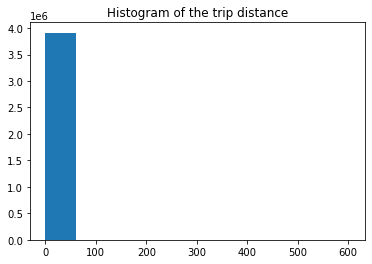

In [18]:
# Plotting histogram of trip distance.
plt.hist(df_merged["Trip_distance"])
plt.title('Histogram of the trip distance')
plt.show()

<AxesSubplot:xlabel='Trip_distance'>

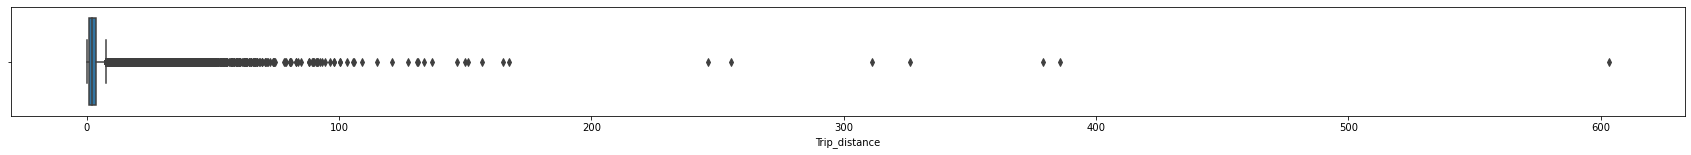

In [19]:
plt.figure(figsize=[30,2])
sns.boxplot(df_merged['Trip_distance'])


In [20]:
#cleaning of the dataset
print(f"There are {df_merged[df_merged['Trip_distance']==0].shape[0]} records with Trip distance being zero.")

There are 57253 records with Trip distance being zero.


In [21]:
#Removing records in which trip distance is 0.
Trip_Distance = df_merged.Trip_distance[df_merged.Trip_distance>0]

#Removing records in which trip distance is 3 standard deviations away from mean.
Trip_Distance = Trip_Distance[(Trip_Distance-Trip_Distance.median()).abs() < 4*Trip_Distance.std()]

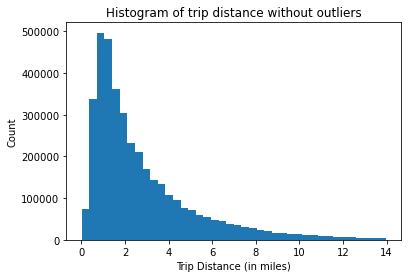

In [22]:
#Plotting histogram with 40 bins.
plt.hist(Trip_Distance,bins = 40)
plt.title('Histogram of trip distance without outliers')
plt.xlabel('Trip Distance (in miles)')
plt.ylabel('Count')
plt.show()

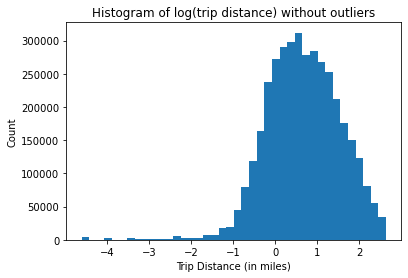

In [23]:

#Plotting histogram with 40 bins.
plt.hist(np.log(Trip_Distance),bins = 40)
plt.title('Histogram of log(trip distance) without outliers')
plt.xlabel('Trip Distance (in miles)')
plt.ylabel('Count')
plt.show()

In [24]:
# developed the func which converts 12 hours to 24 hours time zonw
def timeconvert(str1):
    date = str1.split(' ')[0].replace('/','-')
    time = ' '.join(str1.split(' ')[1:])
#     print (time)
    if time[-2:] == "AM" and time[:2] == "12":
        return str(date + ' ' + "00" + time[2:-2])
    elif time[-2:] == "AM":
        return str(date + ' ' + time[:-2])
    elif time[-2:] == "PM" and time[:2] == "12":
        return str(date + ' ' + time[:-2])
    else:
        return str(date + ' '+str(int(time[:2]) + 12)) + time[2:8]

In [25]:
df_merged["pickup_datetime"] = df_merged['pickup_datetime'].apply(lambda x: timeconvert(x).strip())
df_merged["dropoff_datetime"] = df_merged['dropoff_datetime'].apply(lambda x: timeconvert(x).strip())

In [26]:
df_merged.dtypes

vendorid                   int64
pickup_datetime           object
dropoff_datetime          object
Store_and_fwd_flag        object
rate_code                  int64
Pickup_longitude_x       float64
Pickup_latitude_x        float64
Dropoff_longitude        float64
Dropoff_latitude         float64
Passenger_count            int64
Trip_distance            float64
Fare_amount              float64
Extra                    float64
MTA_tax                  float64
Tip_amount               float64
Tolls_amount             float64
Improvement_surcharge    float64
Total_amount             float64
Payment_type               int64
Trip_type                float64
corr                      object
City                      object
Pickup_latitude_y        float64
Pickup_longitude_y       float64
dtype: object

In [27]:
df_merged['Pickup_Date'] =  pd.to_datetime(df_merged['pickup_datetime'], format="%m-%d-%Y %H:%M:%S")
df_merged['Dropoff_Date'] =  pd.to_datetime(df_merged['dropoff_datetime'], format="%m-%d-%Y %H:%M:%S")
df_merged["Pickup_Hour"] = df_merged['Pickup_Date'].dt.hour

-----Trip distance by hour of the day-----

  Hour    Mean distance    Median distance
------  ---------------  -----------------
     0          3.00741               2.11
     1          2.98088               2.1
     2          3.01044               2.1
     3          3.18321               2.18
     4          3.44532               2.28
     5          4.11061               2.78
     6          4.10785               2.85
     7          3.3171                2.18
     8          3.00125               1.93
     9          2.98147               1.96
    10          2.9335                1.93
    11          2.90515               1.9
    12          2.86938               1.88
    13          2.86235               1.85
    14          2.85269               1.81
    15          2.77674               1.8
    16          2.69582               1.76
    17          2.60105               1.73
    18          2.5816                1.74
    19          2.60983               1.78
    20        

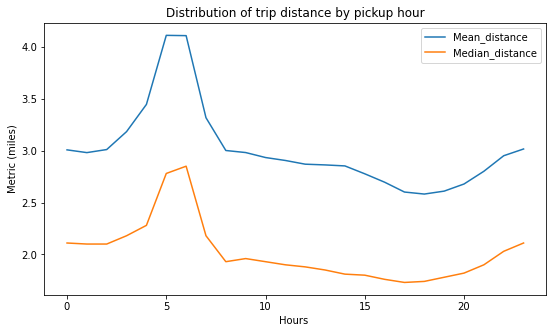

In [28]:
fig,ax = plt.subplots(1,1,figsize=(9,5)) # prepare fig to plot mean and median values
# use a pivot table to aggregate Trip_distance by hour
table1 = df_merged.pivot_table(index='Pickup_Hour', values='Trip_distance',aggfunc=('mean','median')).reset_index()
# rename columns
table1.columns = ['Hour','Mean_distance','Median_distance']
table1[['Mean_distance','Median_distance']].plot(ax=ax)
plt.ylabel('Metric (miles)')
plt.xlabel('Hours ')
plt.title('Distribution of trip distance by pickup hour')
print ('-----Trip distance by hour of the day-----\n')
print (tabulate(table1.values.tolist(),["Hour","Mean distance","Median distance"]))

In [29]:
df_merged.columns

Index(['vendorid', 'pickup_datetime', 'dropoff_datetime', 'Store_and_fwd_flag',
       'rate_code', 'Pickup_longitude_x', 'Pickup_latitude_x',
       'Dropoff_longitude', 'Dropoff_latitude', 'Passenger_count',
       'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount',
       'Tolls_amount', 'Improvement_surcharge', 'Total_amount', 'Payment_type',
       'Trip_type', 'corr', 'City', 'Pickup_latitude_y', 'Pickup_longitude_y',
       'Pickup_Date', 'Dropoff_Date', 'Pickup_Hour'],
      dtype='object')

In [30]:
# Keeping in mind to build features which will be used, therefore remove the unwanted coloumns if present
df_features = df_merged[['vendorid', 'pickup_datetime', 'dropoff_datetime', 'Store_and_fwd_flag',
       'rate_code',
       'Dropoff_longitude', 'Dropoff_latitude', 'Passenger_count',
       'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount',
       'Tolls_amount', 'Improvement_surcharge', 'Total_amount',
       'Payment_type', 'Trip_type', 'City', 'Pickup_Date', 'Dropoff_Date', 'Pickup_Hour']]

In [31]:
df_features.isna().sum()

vendorid                       0
pickup_datetime                0
dropoff_datetime               0
Store_and_fwd_flag             0
rate_code                      0
Dropoff_longitude              0
Dropoff_latitude               0
Passenger_count                0
Trip_distance                  0
Fare_amount                    0
Extra                          0
MTA_tax                        0
Tip_amount                     0
Tolls_amount                   0
Improvement_surcharge          0
Total_amount                   0
Payment_type                   0
Trip_type                     12
City                     2058960
Pickup_Date                    0
Dropoff_Date                   0
Pickup_Hour                    0
dtype: int64

In [32]:
df_features = df_features.dropna()

In [33]:
df_features

,vendorid,pickup_datetime,dropoff_datetime,Store_and_fwd_flag,rate_code,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,...,Tip_amount,Tolls_amount,Improvement_surcharge,Total_amount,Payment_type,Trip_type,City,Pickup_Date,Dropoff_Date,Pickup_Hour
0,2,02-17-2015 05:04:16,02-17-2015 05:34:04,N,1,-73.918312,40.651379,1,3.47,17.0,...,0.0,0.0,0.3,18.3,1,1.0,Brooklyn,2015-02-17 05:04:16,2015-02-17 05:34:04,5
2,1,01-06-2015 14:16:47,01-06-2015 14:26:49,N,1,-73.873062,40.735619,1,1.60,8.0,...,0.0,0.0,0.3,8.8,2,1.0,Corona,2015-01-06 14:16:47,2015-01-06 14:26:49,14
3,1,02-13-2015 19:49:20,02-13-2015 19:53:49,N,1,-74.003479,40.680717,2,0.70,5.0,...,0.0,0.0,0.3,6.8,2,1.0,New York,2015-02-13 19:49:20,2015-02-13 19:53:49,19
4,1,02-28-2015 14:53:21,02-28-2015 15:03:08,N,1,-73.968918,40.799294,1,1.80,8.5,...,1.2,0.0,0.3,10.5,1,1.0,New York,2015-02-28 14:53:21,2015-02-28 15:03:08,14
6,1,02-15-2015 23:19:58,02-15-2015 23:34:32,N,1,-73.936729,40.844696,1,4.40,15.5,...,0.0,0.0,0.3,16.8,2,1.0,New York,2015-02-15 23:19:58,2015-02-15 23:34:32,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3912805,2,06-02-2015 19:05:24,06-02-2015 19:22:09,N,1,-73.900482,40.722618,1,2.39,12.5,...,0.0,0.0,0.3,14.3,2,1.0,Sunnyside,2015-06-02 19:05:24,2015-06-02 19:22:09,19
3912808,2,07-02-2015 23:56:44,07-03-2015 00:05:03,N,1,-73.948700,40.809200,6,1.13,5.5,...,0.0,0.0,0.3,6.8,2,1.0,New York,2015-07-02 23:56:44,2015-07-03 00:05:03,23
3912809,2,03-06-2015 00:07:26,03-06-2015 00:10:26,N,1,-73.915497,40.772141,1,0.91,5.0,...,0.0,0.0,0.3,6.3,2,1.0,Astoria,2015-03-06 00:07:26,2015-03-06 00:10:26,0
3912813,1,12-24-2015 19:59:29,12-24-2015 20:04:52,N,1,-73.994514,40.667416,2,0.90,6.0,...,0.0,0.0,0.3,7.3,2,1.0,Brooklyn,2015-12-24 19:59:29,2015-12-24 20:04:52,19


In [34]:
distribution_of_pickup_based_cities = df_features.groupby('City').count()
distribution_of_pickup_based_cities = distribution_of_pickup_based_cities.loc[:, ['Pickup_Hour']]
distribution_of_pickup_based_cities.columns = ['total']
distribution_of_pickup_based_cities.head()

,total
City,
Albertson,1
Arverne,76
Astoria,148225
Bayside,424
Bellerose,32


In [35]:
distribution_cities_based_on_hours = df_features.loc[:,['Pickup_Hour', 'City']]
distribution_cities_based_on_hours

,Pickup_Hour,City
0,5,Brooklyn
2,14,Corona
3,19,New York
4,14,New York
6,23,New York
...,...,...
3912805,19,Sunnyside
3912808,23,New York
3912809,0,Astoria
3912813,19,Brooklyn


In [36]:
for i in range(0, 24):
    # distributing pickup or taxi requirement according to hours
    df_hour_city = distribution_cities_based_on_hours[distribution_cities_based_on_hours.Pickup_Hour == i]
    # Aggregate hourly based on City
    df_hour_city = df_hour_city.groupby('City').count()
    temp_name = "Pickup_Hour_{}".format(i)
    df_hour_city[temp_name] = df_hour_city['Pickup_Hour']
    df_hour_city = df_hour_city.loc[:, temp_name]
    df_hour_city = df_hour_city.to_frame()
    # Join the temporary dataframe onto the large final dataframe
    distribution_of_pickup_based_cities = distribution_of_pickup_based_cities.join(df_hour_city, how='left')

In [37]:
distribution_of_pickup_based_cities.fillna(0, inplace=True)
distribution_of_pickup_based_cities

,total,Pickup_Hour_0,Pickup_Hour_1,Pickup_Hour_2,Pickup_Hour_3,Pickup_Hour_4,Pickup_Hour_5,Pickup_Hour_6,Pickup_Hour_7,Pickup_Hour_8,...,Pickup_Hour_14,Pickup_Hour_15,Pickup_Hour_16,Pickup_Hour_17,Pickup_Hour_18,Pickup_Hour_19,Pickup_Hour_20,Pickup_Hour_21,Pickup_Hour_22,Pickup_Hour_23
City,,,,,,,,,,,,,,,,,,,,,
Albertson,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Arverne,76,4.0,1.0,1.0,3.0,1.0,1.0,0.0,1.0,2.0,...,2.0,6.0,3.0,5.0,5.0,6.0,7.0,5.0,7.0,4.0
Astoria,148225,7308.0,6190.0,4723.0,3842.0,3444.0,2389.0,2410.0,3614.0,5303.0,...,6403.0,6398.0,7160.0,8019.0,9061.0,9045.0,8879.0,8617.0,8712.0,8252.0
Bayside,424,34.0,41.0,52.0,47.0,27.0,8.0,4.0,5.0,11.0,...,11.0,11.0,42.0,21.0,6.0,8.0,6.0,8.0,15.0,10.0
Bellerose,32,1.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,3.0,...,4.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williston Park,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Woodhaven,253,10.0,14.0,19.0,9.0,16.0,6.0,6.0,7.0,9.0,...,6.0,15.0,10.0,13.0,19.0,14.0,19.0,13.0,7.0,12.0
Woodside,5301,247.0,194.0,135.0,123.0,136.0,86.0,66.0,114.0,172.0,...,216.0,243.0,274.0,308.0,347.0,398.0,356.0,372.0,303.0,289.0


In [38]:
'''
Scaling/Normalizing the data as every city have different total count of the pickup, 
if not done - City with largest number of the pickup will have the dominating clusters
'''
distribution_of_pickup_based_cities = distribution_of_pickup_based_cities.iloc[:,1:].div(
                                            distribution_of_pickup_based_cities.total, axis=0)

In [39]:
distribution_of_pickup_based_cities

,Pickup_Hour_0,Pickup_Hour_1,Pickup_Hour_2,Pickup_Hour_3,Pickup_Hour_4,Pickup_Hour_5,Pickup_Hour_6,Pickup_Hour_7,Pickup_Hour_8,Pickup_Hour_9,...,Pickup_Hour_14,Pickup_Hour_15,Pickup_Hour_16,Pickup_Hour_17,Pickup_Hour_18,Pickup_Hour_19,Pickup_Hour_20,Pickup_Hour_21,Pickup_Hour_22,Pickup_Hour_23
City,,,,,,,,,,,,,,,,,,,,,
Albertson,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Arverne,0.052632,0.013158,0.013158,0.039474,0.013158,0.013158,0.000000,0.013158,0.026316,0.000000,...,0.026316,0.078947,0.039474,0.065789,0.065789,0.078947,0.092105,0.065789,0.092105,0.052632
Astoria,0.049303,0.041761,0.031864,0.025920,0.023235,0.016117,0.016259,0.024382,0.035777,0.038900,...,0.043198,0.043164,0.048305,0.054100,0.061130,0.061022,0.059902,0.058135,0.058776,0.055672
Bayside,0.080189,0.096698,0.122642,0.110849,0.063679,0.018868,0.009434,0.011792,0.025943,0.028302,...,0.025943,0.025943,0.099057,0.049528,0.014151,0.018868,0.014151,0.018868,0.035377,0.023585
Bellerose,0.031250,0.000000,0.000000,0.062500,0.062500,0.062500,0.062500,0.031250,0.093750,0.062500,...,0.125000,0.031250,0.000000,0.000000,0.031250,0.031250,0.031250,0.031250,0.000000,0.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williston Park,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Woodhaven,0.039526,0.055336,0.075099,0.035573,0.063241,0.023715,0.023715,0.027668,0.035573,0.023715,...,0.023715,0.059289,0.039526,0.051383,0.075099,0.055336,0.075099,0.051383,0.027668,0.047431
Woodside,0.046595,0.036597,0.025467,0.023203,0.025656,0.016223,0.012450,0.021505,0.032447,0.034145,...,0.040747,0.045840,0.051688,0.058102,0.065459,0.075080,0.067157,0.070175,0.057159,0.054518


In [40]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(distribution_of_pickup_based_cities)
kmeans.labels_

array([0, 0, 0, 0, 0, 7, 6, 0, 7, 0, 0, 7, 0, 3, 0, 0, 0, 3, 0, 4, 0, 0,
       0, 0, 0, 4, 6, 0, 8, 0, 4, 4, 0, 5, 0, 0, 2, 0, 0, 4, 0, 1, 0, 0,
       9, 0, 4, 0, 0, 9, 0, 0, 0, 4, 0, 0, 0, 2, 0, 2, 4, 0, 0, 0, 0, 8,
       4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 7, 0, 4, 4, 1, 4, 0, 0, 0, 0, 0,
       5, 0])

In [41]:
distribution_of_pickup_based_cities['clusters'] = kmeans.labels_

In [42]:
distribution_of_pickup_based_cities

,Pickup_Hour_0,Pickup_Hour_1,Pickup_Hour_2,Pickup_Hour_3,Pickup_Hour_4,Pickup_Hour_5,Pickup_Hour_6,Pickup_Hour_7,Pickup_Hour_8,Pickup_Hour_9,...,Pickup_Hour_15,Pickup_Hour_16,Pickup_Hour_17,Pickup_Hour_18,Pickup_Hour_19,Pickup_Hour_20,Pickup_Hour_21,Pickup_Hour_22,Pickup_Hour_23,clusters
City,,,,,,,,,,,,,,,,,,,,,
Albertson,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0
Arverne,0.052632,0.013158,0.013158,0.039474,0.013158,0.013158,0.000000,0.013158,0.026316,0.000000,...,0.078947,0.039474,0.065789,0.065789,0.078947,0.092105,0.065789,0.092105,0.052632,0
Astoria,0.049303,0.041761,0.031864,0.025920,0.023235,0.016117,0.016259,0.024382,0.035777,0.038900,...,0.043164,0.048305,0.054100,0.061130,0.061022,0.059902,0.058135,0.058776,0.055672,0
Bayside,0.080189,0.096698,0.122642,0.110849,0.063679,0.018868,0.009434,0.011792,0.025943,0.028302,...,0.025943,0.099057,0.049528,0.014151,0.018868,0.014151,0.018868,0.035377,0.023585,0
Bellerose,0.031250,0.000000,0.000000,0.062500,0.062500,0.062500,0.062500,0.031250,0.093750,0.062500,...,0.031250,0.000000,0.000000,0.031250,0.031250,0.031250,0.031250,0.000000,0.062500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williston Park,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
Woodhaven,0.039526,0.055336,0.075099,0.035573,0.063241,0.023715,0.023715,0.027668,0.035573,0.023715,...,0.059289,0.039526,0.051383,0.075099,0.055336,0.075099,0.051383,0.027668,0.047431,0
Woodside,0.046595,0.036597,0.025467,0.023203,0.025656,0.016223,0.012450,0.021505,0.032447,0.034145,...,0.045840,0.051688,0.058102,0.065459,0.075080,0.067157,0.070175,0.057159,0.054518,0


In [43]:
distribution_of_pickup_based_cities['clusters'].unique()

array([0, 7, 6, 3, 4, 8, 5, 2, 1, 9])

In [44]:
# Important factors company would consider if they want to give driver another location
# Distance, Money, Passenger, Pickup hour
df_to_test = df_features[['vendorid',  'Passenger_count',
       'Trip_distance', 'Fare_amount',  'Tip_amount',
       'Total_amount',
        'City',  'Pickup_Hour']]

In [54]:
df_to_test[df_to_test['City'] == 'Woodhaven'].groupby('City').agg(['count', 'mean'])

vendorid           Passenger_count           Trip_distance  \
             count      mean           count      mean         count   
City                                                                   
Woodhaven      253  1.703557             253  1.509881           253   

                    Fare_amount            Tip_amount           Total_amount  \
               mean       count       mean      count      mean        count   
City                                                                           
Woodhaven  3.609447         253  15.288538        253  0.726285          253   

                    Pickup_Hour             
               mean       count       mean  
City                                        
Woodhaven  17.03087         253  11.972332

In [61]:
df_to_test_k_means = df_to_test.groupby('City').agg(['count', 'mean'])

In [63]:
df_to_test_k_means['clusters'] = kmeans.labels_

In [66]:
df_to_test_k_means['clusters'].unique()

array([0, 7, 6, 3, 4, 8, 5, 2, 1, 9])

In [68]:
df_to_test_k_means[df_to_test_k_means.clusters == 0].shape

(57, 15)

In [77]:
df_to_test_k_means[(df_to_test_k_means['Total_amount']['mean'] > 17.03087) & (df_to_test_k_means.clusters == 0)].shape

(35, 15)

In [78]:
df_to_test_k_means[(df_to_test_k_means['Total_amount']['mean'] > 17.03087) & (df_to_test_k_means['Total_amount']['count'] > 253)].shape

(8, 15)